Import Lib

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')


Loaded the dataset

In [12]:
print("🏥 DIABETES RISK PREDICTION SYSTEM")
print("="*50)
df = pd.read_csv("E:\DSC\data_set\diabetes.csv")  

print(f"Dataset loaded: {df.shape[0]} patients, {df.shape[1]-1} features")
print(f"Diabetes cases: {df['Outcome'].sum()} ({df['Outcome'].mean()*100:.1f}%)")


🏥 DIABETES RISK PREDICTION SYSTEM
Dataset loaded: 768 patients, 8 features
Diabetes cases: 268 (34.9%)


Create new meaningful features

In [13]:
class DiabetesFeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer for diabetes-specific feature engineering"""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        # Handle impossible zero values (replace with median of non-zero values)
        zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        for col in zero_cols:
            if col in X_new.columns:
                median_val = X_new[X_new[col] != 0][col].median()
                X_new[col] = X_new[col].replace(0, median_val)
        
        # Feature Engineering: Create new meaningful features
        
        # 1. BMI Categories (WHO classification)
        X_new['BMI_Category'] = pd.cut(X_new['BMI'], 
                                     bins=[0, 18.5, 25, 30, float('inf')],
                                     labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        
        # 2. Age Groups
        X_new['Age_Group'] = pd.cut(X_new['Age'],
                                  bins=[0, 30, 45, 60, float('inf')],
                                  labels=['Young', 'Middle_aged', 'Senior', 'Elderly'])
        
        # 3. Glucose Risk Level (ADA guidelines)
        X_new['Glucose_Risk'] = pd.cut(X_new['Glucose'],
                                     bins=[0, 100, 126, float('inf')],
                                     labels=['Normal', 'Prediabetic', 'Diabetic'])
        
        # 4. Pregnancy Risk (high pregnancy count)
        X_new['High_Pregnancies'] = (X_new['Pregnancies'] >= 4).astype(int)
        
        # 5. Composite Risk Score
        X_new['Risk_Score'] = (
            (X_new['Glucose'] / 100) * 0.3 +
            (X_new['BMI'] / 40) * 0.3 +
            (X_new['DiabetesPedigreeFunction'] * 2) * 0.2 +
            (X_new['Age'] / 80) * 0.2
        )
        
        # 6. Metabolic indicators
        X_new['Glucose_BMI_Ratio'] = X_new['Glucose'] / X_new['BMI']
        X_new['Insulin_Glucose_Ratio'] = X_new['Insulin'] / X_new['Glucose']
        
        return X_new

Data split

In [14]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split: {X_train.shape[0]} training, {X_test.shape[0]} testing samples")

# Create feature engineering pipeline
feature_engineer = DiabetesFeatureEngineer()
X_train_engineered = feature_engineer.fit_transform(X_train)
X_test_engineered = feature_engineer.transform(X_test)

# Separate numerical and categorical features after engineering
numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
                     'High_Pregnancies', 'Risk_Score', 'Glucose_BMI_Ratio', 'Insulin_Glucose_Ratio']
categorical_features = ['BMI_Category', 'Age_Group', 'Glucose_Risk']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)  # We'll handle encoding in the pipeline
    ])

# Handle categorical encoding
from sklearn.preprocessing import OneHotEncoder
categorical_preprocessor = OneHotEncoder(drop='first', sparse_output=False)


Data split: 614 training, 154 testing samples


Model(Random Forest & Logistic Regression)

In [ ]:
X_train_final = X_train_engineered[numerical_features + categorical_features].copy()
X_test_final = X_test_engineered[numerical_features + categorical_features].copy()

# Store encoders for later use in prediction function
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    all_values = pd.concat([X_train_engineered[col], X_test_engineered[col]]).astype(str)
    le.fit(all_values)
    label_encoders[col] = le
    
    X_train_final[col] = le.transform(X_train_final[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print("\n🤖 TRAINING MULTIPLE MODELS")
print("-" * 30)

# Model 1: Random Forest 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, 
                                class_weight='balanced')  # Handle class imbalance

# Model 2: Logistic Regression 
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Train models
models = {
    'Random Forest': rf_model,
    'Logistic Regression': lr_model
}

model_results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'test_auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Cross-Val F1: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"  Test AUC: {auc_score:.3f}")


🤖 TRAINING MULTIPLE MODELS
------------------------------
Random Forest:
  Cross-Val F1: 0.630 (±0.049)
  Test AUC: 0.829
Logistic Regression:
  Cross-Val F1: 0.662 (±0.036)
  Test AUC: 0.821


DETAILED EVALUATION - Random Forest

In [16]:
best_model_name = 'Random Forest'
best_model = model_results[best_model_name]['model']
y_pred_best = model_results[best_model_name]['predictions']
y_pred_proba_best = model_results[best_model_name]['probabilities']

print(f"\n📊 DETAILED EVALUATION - {best_model_name}")
print("=" * 50)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['No Diabetes', 'Diabetes']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives:  {cm[1,1]}")

# Feature Importance (for Random Forest)
if best_model_name == 'Random Forest':
    feature_names = numerical_features + categorical_features
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🔍 TOP FEATURE IMPORTANCE:")
    print("-" * 30)
    for idx, row in feature_importance.head(8).iterrows():
        print(f"{row['feature']:20}: {row['importance']:.3f}")




📊 DETAILED EVALUATION - Random Forest

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.77      0.86      0.82       100
    Diabetes       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154


Confusion Matrix:
True Negatives:  86 | False Positives: 14
False Negatives: 25 | True Positives:  29

🔍 TOP FEATURE IMPORTANCE:
------------------------------
Risk_Score          : 0.176
Glucose             : 0.138
BMI                 : 0.099
Age                 : 0.074
Glucose_BMI_Ratio   : 0.070
DiabetesPedigreeFunction: 0.069
Insulin_Glucose_Ratio: 0.060
Insulin             : 0.057


HYPERPARAMETER TUNING

In [17]:
print("\n🔧 HYPERPARAMETER TUNING")
print("-" * 30)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid, cv=5, scoring='f1', n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.3f}")

# Update best model with tuned parameters
best_model = grid_search.best_estimator_


🔧 HYPERPARAMETER TUNING
------------------------------
Best parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 score: 0.690


CREATING VISUALIZATIONS


📈 CREATING VISUALIZATIONS
------------------------------


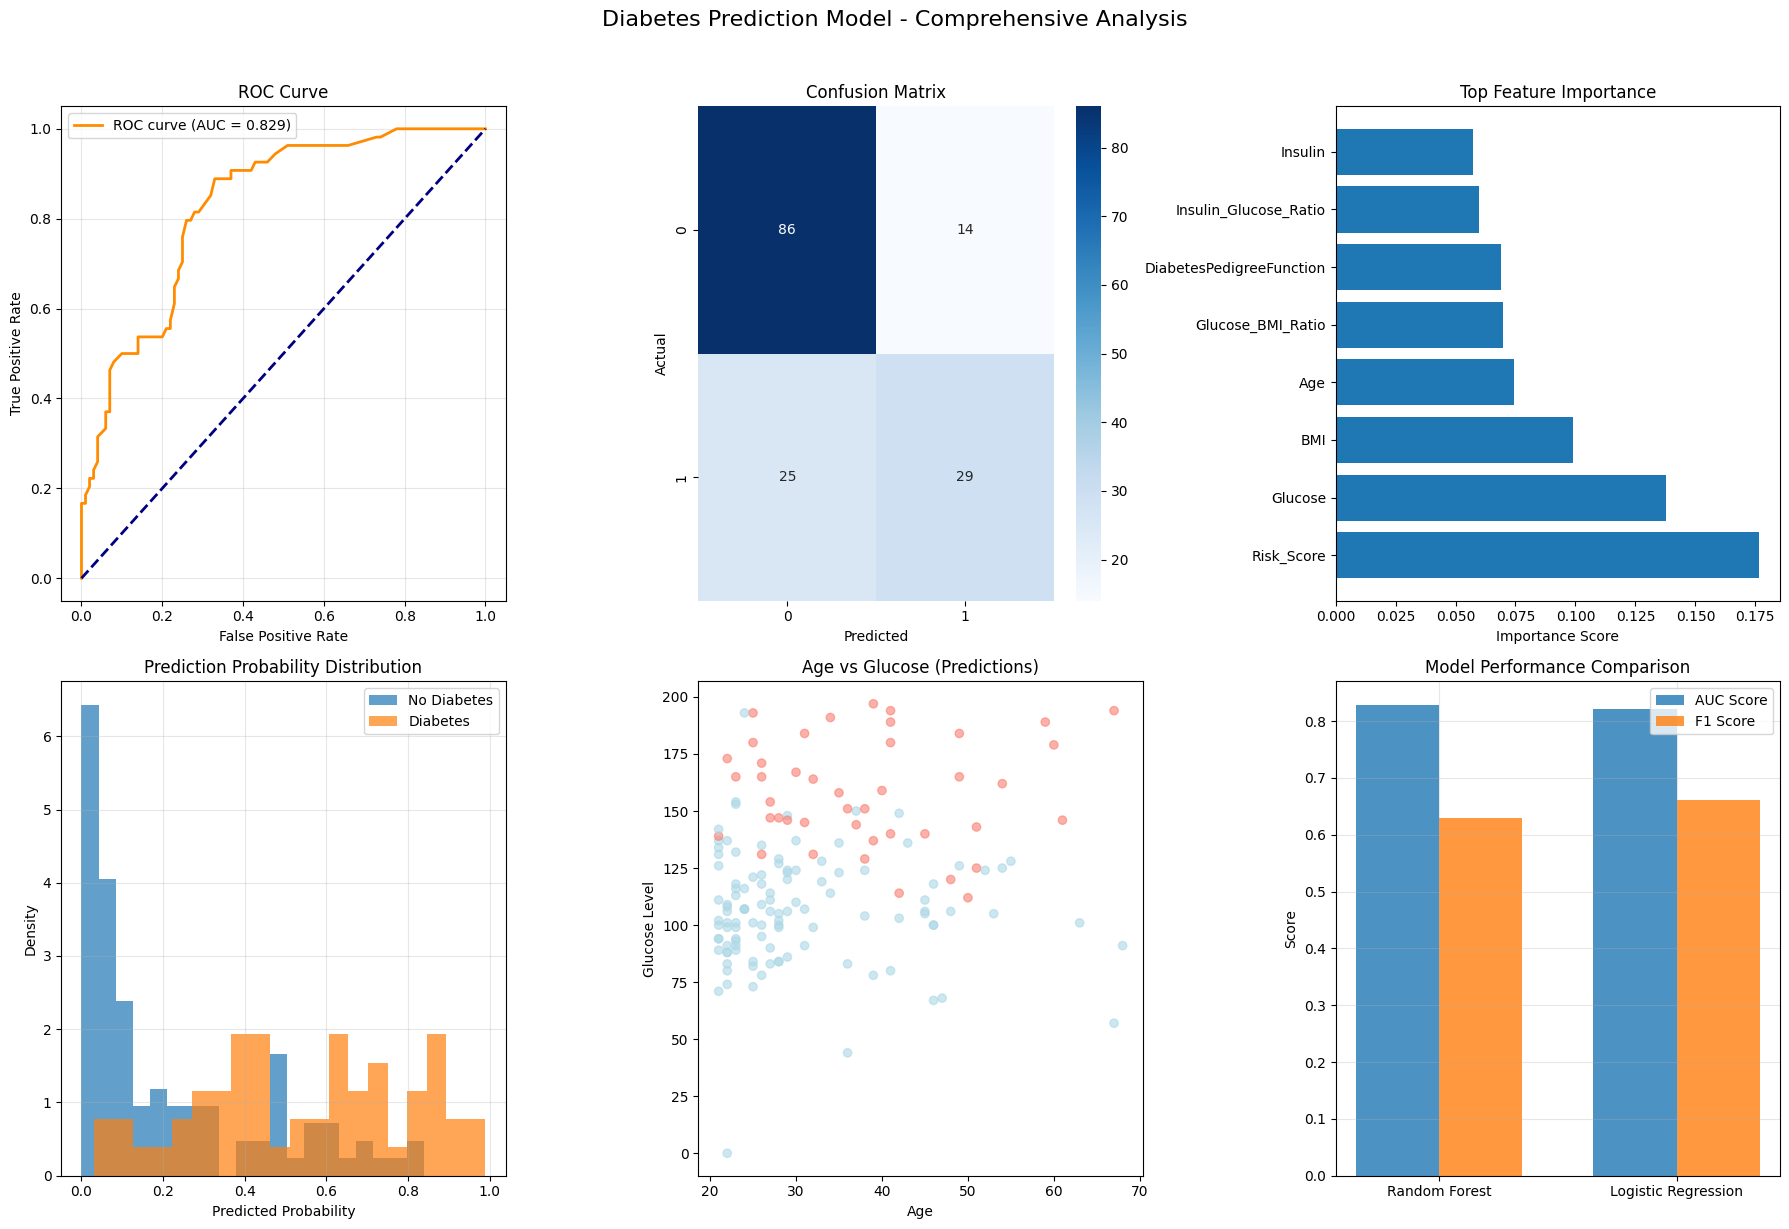

In [18]:
print("\n📈 CREATING VISUALIZATIONS")
print("-" * 30)

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Diabetes Prediction Model - Comprehensive Analysis', fontsize=16, y=1.02)

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})')
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Feature Importance
if best_model_name == 'Random Forest':
    top_features = feature_importance.head(8)
    axes[0,2].barh(top_features['feature'], top_features['importance'])
    axes[0,2].set_title('Top Feature Importance')
    axes[0,2].set_xlabel('Importance Score')

# 4. Prediction Probability Distribution
axes[1,0].hist(y_pred_proba_best[y_test==0], alpha=0.7, label='No Diabetes', bins=20, density=True)
axes[1,0].hist(y_pred_proba_best[y_test==1], alpha=0.7, label='Diabetes', bins=20, density=True)
axes[1,0].set_title('Prediction Probability Distribution')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Age vs Glucose with Predictions
scatter_colors = ['lightblue' if pred == 0 else 'salmon' for pred in y_pred_best]
axes[1,1].scatter(X_test['Age'], X_test['Glucose'], c=scatter_colors, alpha=0.6)
axes[1,1].set_title('Age vs Glucose (Predictions)')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Glucose Level')

# 6. Model Performance Comparison
model_names = list(model_results.keys())
auc_scores = [model_results[name]['test_auc'] for name in model_names]
f1_scores = [model_results[name]['cv_f1_mean'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[1,2].bar(x - width/2, auc_scores, width, label='AUC Score', alpha=0.8)
axes[1,2].bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8)
axes[1,2].set_title('Model Performance Comparison')
axes[1,2].set_ylabel('Score')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(model_names)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
print("\n🏥 REAL-WORLD APPLICATION ANALYSIS")
print("=" * 50)

# Risk Stratification
risk_thresholds = [0.3, 0.7]  # Low, Medium, High risk
risk_categories = []

for prob in y_pred_proba_best:
    if prob < risk_thresholds[0]:
        risk_categories.append('Low Risk')
    elif prob < risk_thresholds[1]:
        risk_categories.append('Medium Risk')
    else:
        risk_categories.append('High Risk')

risk_distribution = pd.Series(risk_categories).value_counts()
print("\nRisk Stratification of Test Patients:")
for risk, count in risk_distribution.items():
    percentage = (count / len(y_pred_proba_best)) * 100
    print(f"{risk:12}: {count:3} patients ({percentage:.1f}%)")

# Business Impact Calculation
print("\nBUSINESS IMPACT ANALYSIS:")
print("-" * 30)

# Assumptions for cost-benefit analysis
cost_per_screening = 50  # Cost of additional screening/preventive care
cost_per_missed_case = 5000  # Cost of treating undiagnosed diabetes
cost_per_false_positive = 200  # Cost of unnecessary worry/tests

tn, fp, fn, tp = cm.ravel()
total_cost_savings = (
    tp * cost_per_missed_case -  # Cases caught early
    fp * cost_per_false_positive -  # False alarms
    (tp + fp) * cost_per_screening  # Screening costs
)

print(f"Potential annual cost savings per 1000 patients: ${total_cost_savings * (1000/len(y_test)):,.0f}")
print(f"True Positive Rate (Sensitivity): {tp/(tp+fn):.1%}")
print(f"True Negative Rate (Specificity): {tn/(tn+fp):.1%}")



🏥 REAL-WORLD APPLICATION ANALYSIS

Risk Stratification of Test Patients:
Low Risk    :  81 patients (52.6%)
Medium Risk :  49 patients (31.8%)
High Risk   :  24 patients (15.6%)

BUSINESS IMPACT ANALYSIS:
------------------------------
Potential annual cost savings per 1000 patients: $909,416
True Positive Rate (Sensitivity): 53.7%
True Negative Rate (Specificity): 86.0%


REAL-WORLD APPLICATION ANALYSIS

In [20]:
def predict_diabetes_risk(patient_data):
    """
    Clinical decision support function for new patients
    
    Args:
        patient_data: dict with patient information
    
    Returns:
        dict with prediction and recommendations
    """
    # Convert to DataFrame
    patient_df = pd.DataFrame([patient_data])
    
    # Apply feature engineering
    patient_engineered = feature_engineer.transform(patient_df)
    patient_final = patient_engineered[numerical_features + categorical_features].copy()
    
# Encode categorical variables (using pre-fitted encoders)
    for col in categorical_features:
        try:
            patient_final[col] = label_encoders[col].transform(patient_final[col].astype(str))
        except ValueError as e:
            # Handle unseen categories by using the most common category
            most_common = label_encoders[col].classes_[0]
            print(f"Warning: Unseen category in {col}. Using default: {most_common}")
            patient_final[col] = label_encoders[col].transform([most_common])
    # Scale features
    patient_scaled = scaler.transform(patient_final)
    
    # Make prediction
    probability = best_model.predict_proba(patient_scaled)[0, 1]
    prediction = best_model.predict(patient_scaled)[0]
    
    # Determine risk level
    if probability < 0.3:
        risk_level = "Low Risk"
        recommendation = "Continue regular health maintenance. Rescreen annually."
    elif probability < 0.7:
        risk_level = "Medium Risk"  
        recommendation = "Recommend lifestyle modifications and screening every 6 months."
    else:
        risk_level = "High Risk"
        recommendation = "Refer for immediate diagnostic testing and endocrinology consultation."
    
    return {
        'diabetes_probability': probability,
        'prediction': 'Diabetes' if prediction == 1 else 'No Diabetes',
        'risk_level': risk_level,
        'recommendation': recommendation
    }

# Example prediction for a new patient
print("\n👨‍⚕️ CLINICAL DECISION SUPPORT EXAMPLE")
print("=" * 50)

sample_patient = {
    'Pregnancies': 2,
    'Glucose': 130,
    'BloodPressure': 80,
    'SkinThickness': 25,
    'Insulin': 100,
    'BMI': 28.5,
    'DiabetesPedigreeFunction': 0.8,
    'Age': 45
}

result = predict_diabetes_risk(sample_patient)
print(f"Patient Profile: {sample_patient}")
print(f"\nPrediction Results:")
print(f"  Diabetes Probability: {result['diabetes_probability']:.1%}")
print(f"  Risk Level: {result['risk_level']}")
print(f"  Clinical Recommendation: {result['recommendation']}")

print("\n✅ DIABETES PREDICTION PIPELINE COMPLETE!")
print("=" * 50)
print("The model is ready for clinical deployment with proper validation.")



👨‍⚕️ CLINICAL DECISION SUPPORT EXAMPLE
Patient Profile: {'Pregnancies': 2, 'Glucose': 130, 'BloodPressure': 80, 'SkinThickness': 25, 'Insulin': 100, 'BMI': 28.5, 'DiabetesPedigreeFunction': 0.8, 'Age': 45}

Prediction Results:
  Diabetes Probability: 59.6%
  Risk Level: Medium Risk
  Clinical Recommendation: Recommend lifestyle modifications and screening every 6 months.

✅ DIABETES PREDICTION PIPELINE COMPLETE!
The model is ready for clinical deployment with proper validation.
